In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

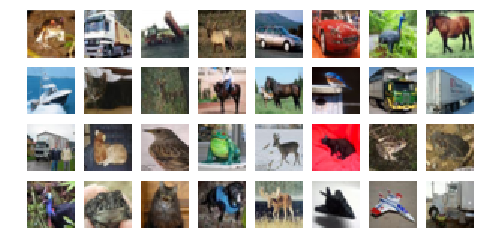

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

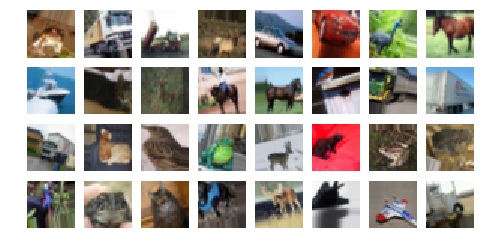

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

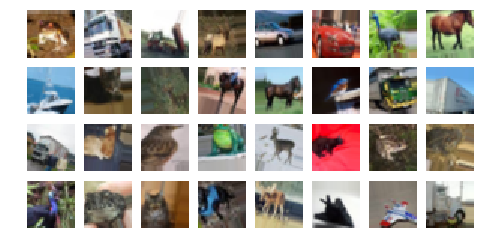

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [2]:
import math
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D
from keras.layers import Dense, Flatten, Activation
from keras.regularizers import l2

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
def process_y(y):
    y = to_categorical(y)
    return y

y_train = process_y(y_train)
y_test = process_y(y_test)

In [5]:
img_size = x_train.shape[1:]
print(img_size)

(32, 32, 3)


In [6]:
def build_cnn(input_shape, dense_neuron, output_shape):
    input_layer = Input(shape=input_shape)
    con = Conv2D(filters=32, kernel_size=(3, 3))(input_layer)
    maxpool = MaxPool2D()(con)
    con = Conv2D(filters=32, kernel_size=(3, 3))(maxpool)
    maxpool = MaxPool2D()(con)
    
    flatten_layer = Flatten()(maxpool)
    for ind, num in enumerate(dense_neuron):
        if ind == 0:
            dense_layer = Dense(units=num, kernel_regularizer=l2())(flatten_layer)
            act = Activation(activation='relu')(dense_layer)
        else:
            dense_layer = Dense(units=num, kernel_regularizer=l2())(act)
            act = Activation(activation='relu')(dense_layer)
    output = Dense(units=output_shape, activation='softmax')(act)
    model = Model(inputs=[input_layer], outputs=[output])
    return model

In [7]:
INPUT_SHAPE = img_size
LEARNING_RATE = 1e-8
BATCH_SIZE = 256
DENSE_NEURON = [256, 256]
OUTPUT_SHAPE = 10
EPOCHS = 5
STEP_PRE_EPOCH = math.ceil(x_train.shape[0]/BATCH_SIZE)

In [8]:
train_gen= ImageDataGenerator(rotation_range=20, rescale= 1./255.,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True)
train_gen.fit(x_train)
train_generator = train_gen.flow(x_train, y_train, batch_size=BATCH_SIZE)

test_gen = ImageDataGenerator(rescale=1./255.)
test_gen.fit(x_test)
test_generator = test_gen.flow(x_test, y_test, batch_size=32)

In [9]:
model = build_cnn(input_shape=INPUT_SHAPE, dense_neuron=DENSE_NEURON,
                  output_shape=OUTPUT_SHAPE)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(train_generator, steps_per_epoch=STEP_PRE_EPOCH, epochs=EPOCHS)

Epoch 1/5
196/196 [==============================] - 33s 169ms/step - loss: 3.0868 - acc: 0.2920
Epoch 2/5
196/196 [==============================] - 35s 177ms/step - loss: 1.8938 - acc: 0.3575
Epoch 3/5
196/196 [==============================] - 34s 174ms/step - loss: 1.7937 - acc: 0.3924
Epoch 4/5
196/196 [==============================] - 34s 171ms/step - loss: 1.7580 - acc: 0.4038
Epoch 5/5
196/196 [==============================] - 33s 170ms/step - loss: 1.7049 - acc: 0.4225


In [10]:
loss, acc = model.evaluate_generator(test_generator)

In [11]:
print('Accuracy: {:.2f} %'.format(acc * 100))

Accuracy: 43.74 %
